_Version log: Merging V13 and V24 so that we can optimise 2D interferograms_

In [1]:
import sys
from sklearn.linear_model import Lasso #I'm using scikit insted of svxpy to solve.
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft as spfft, interpolate as spinter
from PIL import Image #I prefer Pillow to imageio
from astropy.io import fits
from tqdm import tqdm
#np.set_printoptions(threshold=sys.maxsize)

To turn a sparce signal $X$ into the full image $Y$. The L1 norm of,
\begin{equation}
    \mathcal{F} (Y),
\end{equation}
needs to be minimised while also minimising the L2 norm of,
\begin{equation}
    C \times \mathcal{F}^{-1} (I) \times \mathcal{F} (Y) - X,
\end{equation}
where $\mathcal{F}( )$ is the DCT, $I$ is an identerty matrix and $C$ is a cropping transformation matrix such that,
\begin{equation}
    C \times Y = X.
\end{equation}
The weighting between the first two equation can be changed using the regularisation coeffient, $\alpha$. Altogether the function that needs to be minimised looks like,
\begin{equation}
    ||C \times \mathcal{F}^{-1} (I) \times \mathcal{F} (Y) - X||_{2} + \alpha ||\mathcal{F} (Y)||_{1},
\end{equation}
which can be re-writtern in terms of the measurement matrix $A$ and $\mathcal{F} (Y) = Z$ as,
\begin{equation}
    ||A \times Z - X||_{2} + \alpha ||Z||_{1}.
\end{equation}

In [2]:
def interpolate(image, compression):
    shape = image.shape
    grid_ticks = [range(length) for length in shape]
    linear_interpolation = spinter.RegularGridInterpolator(grid_ticks, image, method='linear', bounds_error=False, fill_value= None) # interp2d is going to be deprecated :( 

    new_shape = np.round(np.array(shape)*compression)
    mgrid_slices = [slice(0, length, 1j*new_length) for length, new_length in zip(shape, new_shape)]
    new_coords = tuple(np.mgrid[*mgrid_slices]) # RegularGridInterpolator is a pain in the ass because it almost works with np.meshgrid but not quite. np.meshgrid returns a list but Interpolator expects a tuple.

    return linear_interpolation(new_coords)

def open_compressed_image(file_name, file_type, compression):
    if file_type == ".png" or file_type == ".jpg": # for test images such as erscher's waterfall and alfie
        img = Image.open("data\\" + file_name + file_type) # read image
        img = np.array(img).sum(axis=2) # make image grayscale
        array = interpolate(img, compression)
        uncertainty = np.ones_like(array) # uncertainty is unknown. chi^2 = norm when uncertainty = 1.

    elif file_type == ".csv": # for real data from pyro and xeva
        with open("data\\" + file_name + file_type, 'r') as file: #openai did this bit for me. It automatically detects which delimiter to use (pyro uses , xeva uses ;)
            first_line = file.readline()
            if ';' in first_line:
                delimiter = ';'
            else:
                delimiter = ','
        img = np.loadtxt("data\\" + file_name + file_type, delimiter=delimiter)
        array = interpolate(img, compression)
        uncertainty = np.ones_like(array) # uncertainty is unknown. chi^2 = norm when uncertainty = 1.

    elif file_type == ".fits": # for mock data
        hdul = fits.open('data\\' + file_name + file_type)
        array = np.array(hdul["primary"].data) # or hdul[0]
        uncertainty = np.array(hdul["uncertainty"].data) # or hdul[1]
        hdul.close()
        array = interpolate(array, compression)
        uncertainty = interpolate(uncertainty, compression)
    else:
        raise ValueError("{0:} is not a regonised file type.".format(file_type))
    return array, uncertainty

def subsample_2d(array, subsampling_percentage = 0.5, subsampling_method = "random"):
    
    array_flat = array.flatten()
    total_points = np.multiply(*array.shape)
    total_rows, total_columns = array.shape

    if subsampling_method == "random":
        reduced_points = round(total_points *subsampling_percentage)
        subsampled_points = np.random.choice(total_points, reduced_points, replace= False)
    if subsampling_method == "random_columns":
        reduced_columns = round(total_columns *subsampling_percentage)
        subsampled_columns = np.random.choice(total_columns, reduced_columns, replace= False)
        subsampled_points = [subsampled_columns + row_number*total_columns for row_number in range(total_rows)]
        subsampled_points = np.array(subsampled_points).flatten()
    if subsampling_method == "random_rows":
        reduced_rows = round(total_rows *subsampling_percentage)
        subsampled_rows = np.random.choice(total_rows, reduced_rows, replace= False)
        subsampled_points = [column_number + subsampled_rows*total_columns for column_number in range(total_columns)]
        subsampled_points = np.array(subsampled_points).flatten()

    if subsampling_method == "regular_columns":
        reduced_columns = round(total_columns *subsampling_percentage)
        subsampled_columns = np.round(np.linspace(0, total_columns -1, reduced_columns)).astype(int)
        subsampled_points = [subsampled_columns + row_number*total_columns for row_number in range(total_rows)]
        subsampled_points = np.array(subsampled_points).flatten()
    if subsampling_method == "regular_rows":
        reduced_rows = round(total_rows *subsampling_percentage)
        subsampled_rows = np.round(np.linspace(0, total_rows -1, reduced_rows)).astype(int)
        subsampled_points = [column_number + subsampled_rows*total_columns for column_number in range(total_columns)]
        subsampled_points = np.array(subsampled_points).flatten()
    if subsampling_method == "regular_grid":
        reduced_columns = round(total_columns *subsampling_percentage**0.5)
        subsampled_columns = np.round(np.linspace(0, total_columns -1, reduced_columns)).astype(int)
        reduced_rows = round(total_rows *subsampling_percentage**0.5)
        subsampled_rows = np.round(np.linspace(0, total_rows -1, reduced_rows)).astype(int)
        subsampled_points = [subsampled_columns + row_number*total_columns for row_number in subsampled_rows]
        subsampled_points = np.array(subsampled_points).flatten()

    subsampled_points = np.sort(subsampled_points) #Not nessisary but makes it easier to look at.
    signal_flat = np.full(total_points, np.nan)
    signal_flat[subsampled_points] = array_flat[subsampled_points]
    signal_sparce = array_flat[subsampled_points]
    signal = np.reshape(signal_flat, array.shape)

    return signal, signal_flat, signal_sparce, subsampled_points

def compressed_sensing(samples, alpha):
    locations = np.flatnonzero(~np.isnan(samples)) # Where are the known samples located?
    known_samples = np.ravel(samples)[locations] # What are the known samples?
    reduced_points = len(locations) # How many known samples are there?
    total_points = samples.size # How many pixels do we want to reconstruct?
    idx = np.arange(reduced_points)

    dirac_deltas = np.zeros([reduced_points, total_points])
    dirac_deltas[idx, locations] = 1.
    dirac_deltas = np.reshape(dirac_deltas, (reduced_points, *samples.shape))
    transformation_matrix = spfft.dctn(dirac_deltas, axes= (1,2), type= 2, norm= "ortho") # FORWARD fourier transform of known single pixels (spatial dirac deltas). This should be equivelent to inverse fourier transforms of all frequencies (frequency dirac deltas) and cropping out the unknown pixels.
    transformation_matrix = transformation_matrix.reshape(reduced_points, total_points)

    lasso = Lasso(alpha= alpha)
    lasso.fit(transformation_matrix, known_samples) # solve the minimisation problem
    result_DCT_flat = lasso.coef_

    result_DCT = result_DCT_flat.reshape(signal.shape)
    result = spfft.idctn(result_DCT, type= 2, norm= "ortho")

    return result

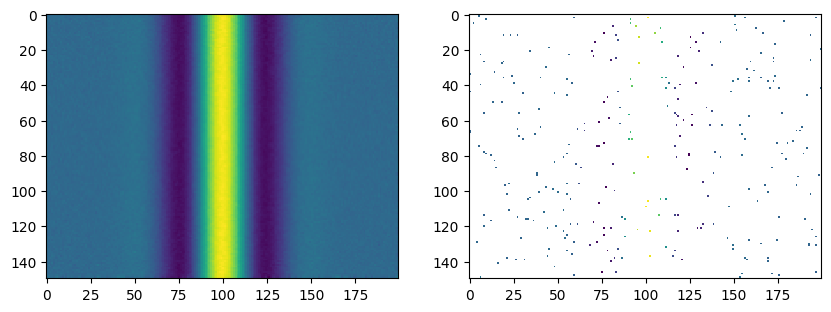

In [3]:
file_name = "2dmock1"
file_type = ".fits"
compression = 1 #fraction of the image to keep (The image is too large to process quickly)
subsample_percentage = 0.01 #fraction of the image to subsample
subsampling_method= "random" #"random" "random_columns" "random_rows" "regular_grid" "regular_columns" "regular_rows"

# original image
target, img = open_compressed_image(file_name, file_type, compression)
total_points = np.multiply(*target.shape)

signal, signal_flat, signal_sparce, random_points_1d = subsample_2d(target, subsampling_method= subsampling_method, subsampling_percentage= subsample_percentage)
random_points_2d = np.argwhere(~np.isnan(signal))

fig, axs = plt.subplots(1,2, figsize= (10, 8))

axs[0].imshow(target, interpolation= "none")
axs[1].imshow(signal, interpolation= "none")

plt.show()

In [5]:
regularization_coeffient = 1e-6 #DECREASE FOR COMPLEX IMAGES (up to 1e-7 (floating point error?)) INCREASE FOR SIMPLE IMAGES (up to 1e-2)
result = compressed_sensing(signal, regularization_coeffient)

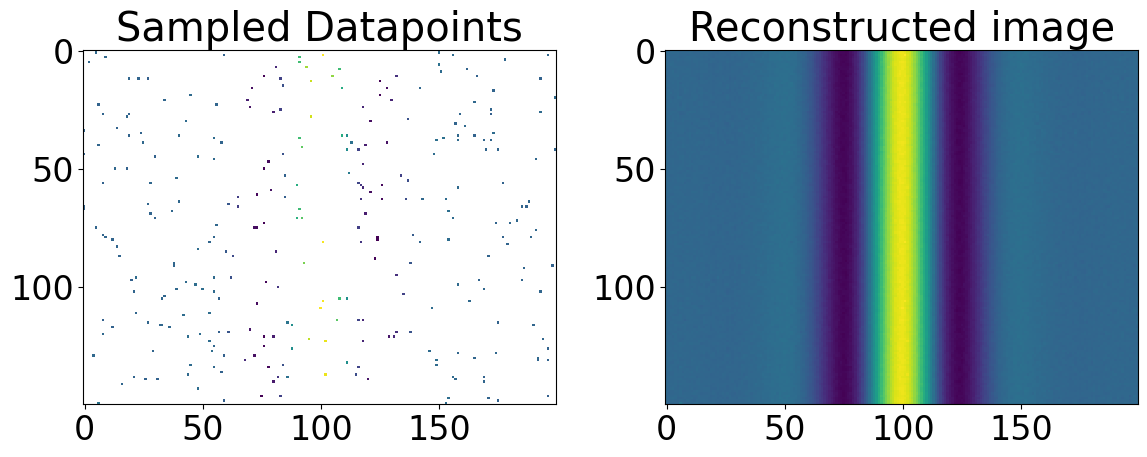

In [6]:
plt.rcParams.update({"font.size":24})

fig, axs = plt.subplots(1,2, figsize= (12,8))

axs[0].imshow(signal, interpolation = "nearest")
axs[0].set_title("Sampled Datapoints")
axs[1].imshow(result, interpolation = "nearest")
axs[1].set_title("Reconstructed image")

plt.tight_layout()

plt.show()

C:\Users\syf83691\AppData\Local\Temp\ipykernel_14840\750508504.py:11: RuntimeWarning: Mean of empty slice
  axs[1][1].plot(np.nanmean(signal, axis= 0), marker= ",")


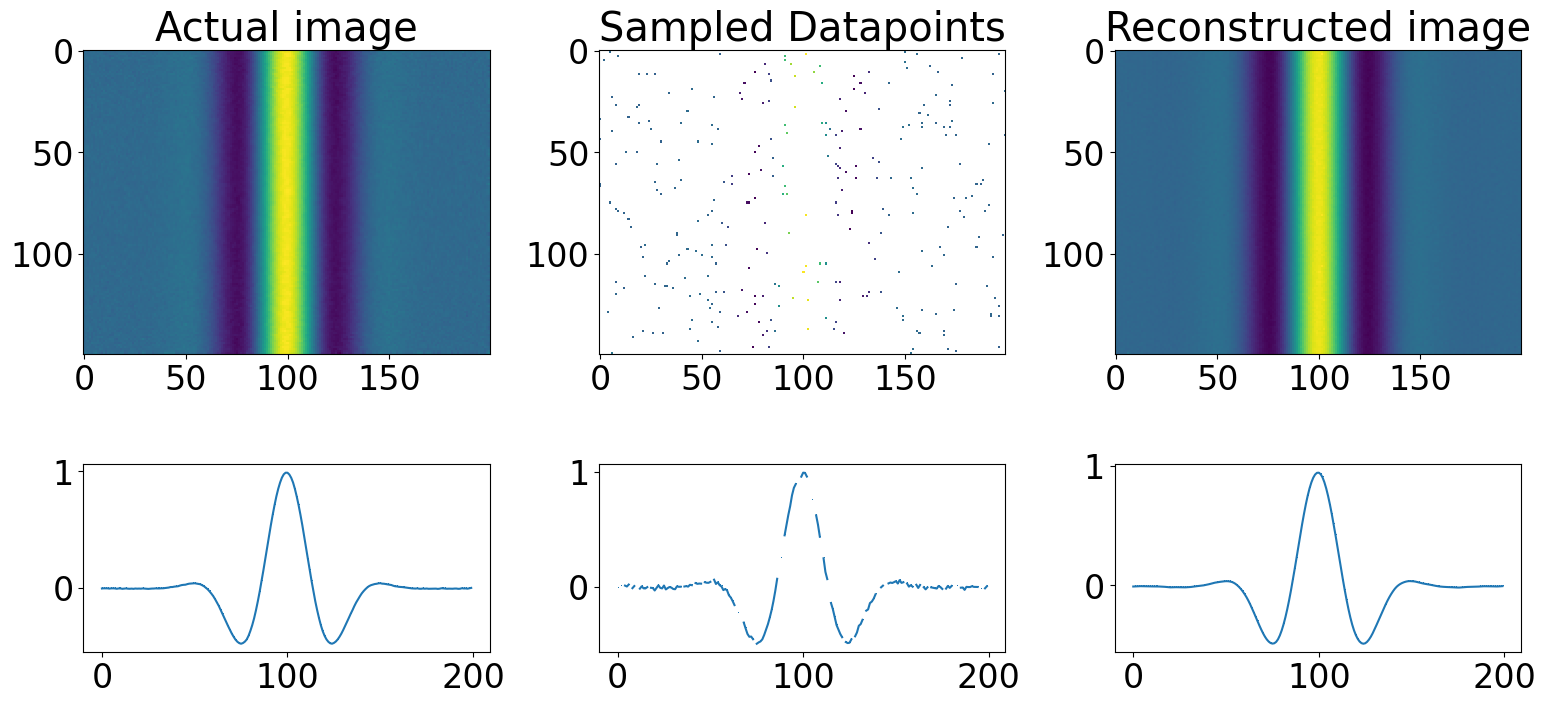

In [7]:
fig, axs = plt.subplots(2,3, figsize= (16,8), height_ratios= [1, 0.4])

axs[0][0].imshow(target, interpolation = "nearest")
axs[0][0].set_title("Actual image")
axs[0][1].imshow(signal, interpolation = "nearest")
axs[0][1].set_title("Sampled Datapoints")
axs[0][2].imshow(result, interpolation = "nearest")
axs[0][2].set_title("Reconstructed image")

axs[1][0].plot(np.nanmean(target, axis= 0), marker= ",")
axs[1][1].plot(np.nanmean(signal, axis= 0), marker= ",")
axs[1][2].plot(np.nanmean(result, axis= 0), marker= ",")

plt.tight_layout()
plt.show()